In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PairwiseAlignment import pairAlign
from sklearn.neighbors import KernelDensity

## Pre-processing steps

* ``GetSequencesPerVJ.py`` - Reads allinfo table, select entries for the top VJ or specified VJ combination, writes sequences to disk
  * Input: allinfo_files. These are the output from the RESEDA pipeline. Files end with -IGH_HUMAN-all_info.csv.rr.all_info.csv
  * Output: fasta files
* ``./clustalo -i input.fasta -o output.clustalo.fasta`` - Multiple sequence alignment of the fasta sequences from the previous step
* ``SharedMutations.py`` - Determines mutations compared to the germline sequence and compares antibody sequences pairwise to count the number of shared mutations
  * Input: clustalo.fasta file(s)
  * Output: list of mutations and list of shared mutations
* ``CheckHighSharedMutations.ipynb`` (this script) work in progress to cluster related antibody sequences
  * calculates the distance between CDR3 sequences
  * analysis of CDR3 distance and number of shared mutations
  * an approach to combine the CDR3 distance and shared mutation information to define a threshold for related vs unrelated sequences
  * create a graph of related sequences and fetch the connected antibody sequences

## Possible improvements

* A multiple sequence alignment might introduce alignment errors in case sequences are not related (to do: check if this happens). An alternative would be to align all sequences to the germline sequence and determine the mutations
* The function to combine the information of CDR3 distance and number of shared mutations is perhaps too simplistic. Discuss whether a more suffisticated function is needed.


In [2]:
infile = "./tmp-shared-mutations/DO-051V1-CD24m-U_S113.V.clustalo.fasta.shared-mutations.csv"
outfile = infile + ".dist.csv"
clusterfile = infile + ".clusters.csv"

In [3]:
df = pd.read_csv(infile, sep="\t")
print(len(df))
df.head()

763230


,Reference,Antibody 1,Antibody 2,Shared mutations,Perc AB1,Perc AB2
0,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:2105:9313:15262|D...,4,10.8,11.8
1,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:1119:27736:20096|...,4,10.8,12.1
2,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:2103:20887:15385|...,4,10.8,12.5
3,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:1118:14475:15886|...,4,10.8,12.5
4,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:2111:19663:10811|...,4,10.8,12.5


In [4]:
get_cdr3 = lambda x: x.split("|")[-1].split(",")[0]
df["cdr3_AB1"] = [x for x in map(get_cdr3, df["Antibody 1"])]
df["cdr3_AB2"] = [x for x in map(get_cdr3, df["Antibody 2"])]
df.head()

,Reference,Antibody 1,Antibody 2,Shared mutations,Perc AB1,Perc AB2,cdr3_AB1,cdr3_AB2
0,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:2105:9313:15262|D...,4,10.8,11.8,TGTGCGAGACACCGTGGGAGTTCGTTAGGCGGCCGCCTAGATAACT...,TGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...
1,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:1119:27736:20096|...,4,10.8,12.1,TGTGCGAGACACCGTGGGAGTTCGTTAGGCGGCCGCCTAGATAACT...,TGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...
2,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:2103:20887:15385|...,4,10.8,12.5,TGTGCGAGACACCGTGGGAGTTCGTTAGGCGGCCGCCTAGATAACT...,TGTACGAGACTGC
3,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:1118:14475:15886|...,4,10.8,12.5,TGTGCGAGACACCGTGGGAGTTCGTTAGGCGGCCGCCTAGATAACT...,TGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...
4,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:2111:19663:10811|...,4,10.8,12.5,TGTGCGAGACACCGTGGGAGTTCGTTAGGCGGCCGCCTAGATAACT...,TGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...


In [5]:
pairAlign(df.iloc[0]['cdr3_AB1'], df.iloc[0]['cdr3_AB2']).distance

23

In [6]:
df_unique = df.groupby(["cdr3_AB1", "cdr3_AB2"]).agg({"Reference": len})
df_unique = df_unique.reset_index()
print(len(df_unique))
df_unique.head()

4773


,cdr3_AB1,cdr3_AB2,Reference
0,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,1
1,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,1
2,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,M02984:889:000000000-JGK5F:1:2101:836,1
3,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,TGCTGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTG...,1
4,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,TGTACAAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,2


In [7]:
df_unique['cdr3_distance'] = [x.distance for x in map(pairAlign, df_unique['cdr3_AB1'], df_unique['cdr3_AB2'])]
df_unique.head()

,cdr3_AB1,cdr3_AB2,Reference,cdr3_distance
0,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,1,0
1,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,1,0
2,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,M02984:889:000000000-JGK5F:1:2101:836,1,38
3,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,TGCTGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTG...,1,1
4,CGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,TGTACAAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,2,2


In [8]:
cols = ["cdr3_AB1", "cdr3_AB2", "cdr3_distance"]
df_unique = df_unique[cols]
df = pd.merge(df, df_unique, on=["cdr3_AB1", "cdr3_AB2"])
df.head()

,Reference,Antibody 1,Antibody 2,Shared mutations,Perc AB1,Perc AB2,cdr3_AB1,cdr3_AB2,cdr3_distance
0,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:2105:9313:15262|D...,4,10.8,11.8,TGTGCGAGACACCGTGGGAGTTCGTTAGGCGGCCGCCTAGATAACT...,TGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,23
1,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:1118:18419:9784|D...,4,10.8,12.5,TGTGCGAGACACCGTGGGAGTTCGTTAGGCGGCCGCCTAGATAACT...,TGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,23
2,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:1103:2594:17328|D...,4,10.8,11.8,TGTGCGAGACACCGTGGGAGTTCGTTAGGCGGCCGCCTAGATAACT...,TGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,23
3,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:1114:7746:15734|D...,4,10.8,12.5,TGTGCGAGACACCGTGGGAGTTCGTTAGGCGGCCGCCTAGATAACT...,TGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,23
4,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1104:20322:6666|D...,M02984:889:000000000-JGK5F:1:2101:9391:17307|D...,4,10.8,12.5,TGTGCGAGACACCGTGGGAGTTCGTTAGGCGGCCGCCTAGATAACT...,TGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,23


In [9]:
df.to_csv(outfile, sep="\t", index=False)
print("Wrote", outfile, "to disk")

Wrote ./tmp-shared-mutations/DO-051V1-CD24m-U_S113.V.clustalo.fasta.shared-mutations.csv.dist.csv to disk


/home/barbera/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


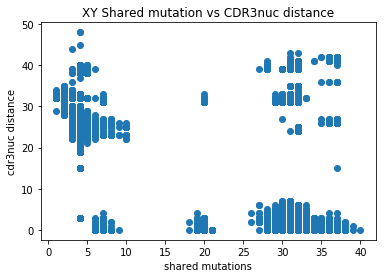

In [10]:
fig, ax = plt.subplots()
ax.scatter(df['Shared mutations'], df['cdr3_distance'])
plt.title("XY Shared mutation vs CDR3nuc distance")
plt.xlabel('shared mutations')
plt.ylabel('cdr3nuc distance')
fig.show()

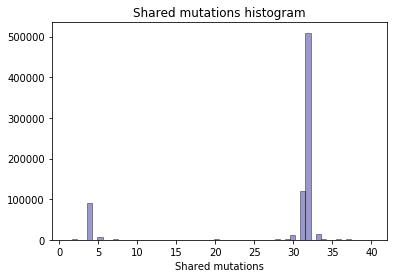

In [11]:
sns.distplot(df['Shared mutations'], hist=True, kde=False, 
             bins=60, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title("Shared mutations histogram")
plt.show()

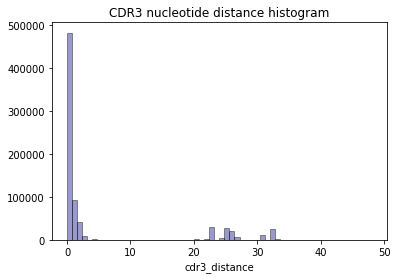

In [12]:
sns.distplot(df['cdr3_distance'], hist=True, kde=False, 
             bins=60, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title("CDR3 nucleotide distance histogram")
plt.show()

## Check the nr of shared mutations between close CDR3s and distant CDR3s

In [13]:
df_close = df[df['cdr3_distance'] < 5]
df_distant = df[df['cdr3_distance'] >= 5]

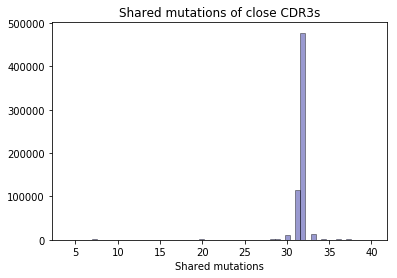

In [14]:
sns.distplot(df_close['Shared mutations'], hist=True, kde=False, 
             bins=60, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title("Shared mutations of close CDR3s")
plt.show()

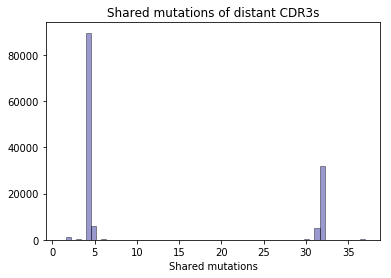

In [15]:
sns.distplot(df_distant['Shared mutations'], hist=True, kde=False, 
             bins=60, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title("Shared mutations of distant CDR3s")
plt.show()

/home/barbera/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


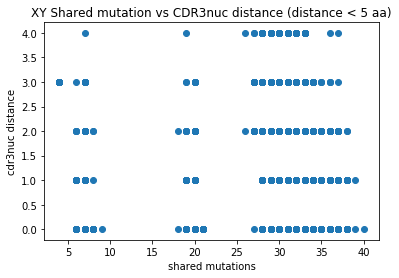

In [16]:
fig, ax = plt.subplots()
ax.scatter(df_close['Shared mutations'], df_close['cdr3_distance'])
plt.title("XY Shared mutation vs CDR3nuc distance (distance < 5 aa)")
plt.xlabel('shared mutations')
plt.ylabel('cdr3nuc distance')
fig.show()

/home/barbera/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


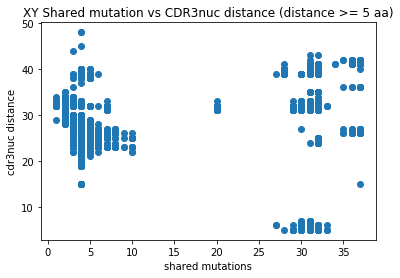

In [17]:
fig, ax = plt.subplots()
ax.scatter(df_distant['Shared mutations'], df_distant['cdr3_distance'])
plt.title("XY Shared mutation vs CDR3nuc distance (distance >= 5 aa)")
plt.xlabel('shared mutations')
plt.ylabel('cdr3nuc distance')
fig.show()

## Create function with combination of cdr3 distance and nr of shared mutations

In [18]:
w_cdr3 = 0.5
w_mut = 0.5
df["myfunc"] = list(w_cdr3 * (df['cdr3_distance'].max() - df['cdr3_distance']) + w_mut * df['Shared mutations'])

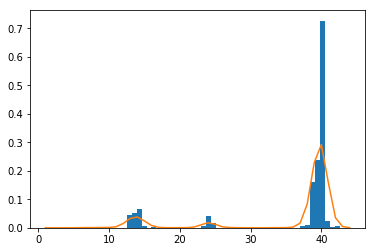

In [19]:
# fit density
sample = df['myfunc'].to_numpy()
model = KernelDensity(bandwidth=1, kernel='gaussian')
sample = sample.reshape((len(sample), 1))
model.fit(sample)
# sample probabilities for a range of outcomes
values = np.asarray([value for value in range(1, int(max(df['myfunc'])) + 1)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = np.exp(probabilities)
# plot the histogram and pdf
plt.hist(sample, bins=60, density=True)
plt.plot(values[:], probabilities)
plt.show()

In [20]:
# Calculate slopes
dydx = np.diff(probabilities)

In [21]:
# check if there are values that are zero
print("Zero's?", 0 in dydx)

# look for minimum and maximum values (dydx switches sign)
minima = list()
maxima = list()
newvalues = values[:-1]
for i in range(len(dydx)-1):
    j = i + 1
    if dydx[i] * dydx[j] < 0:
        # print(dydx[i], dydx[j], newvalues[i], newvalues[j])
        if dydx[i] < 0:
            minima.append(int(newvalues[j]))
        else:
            maxima.append(int(newvalues[j]))
print("Minima:", minima)
print("Maxima:", maxima)
threshold = minima[-1]
print("Threshold:", threshold)

Zero's? False
Minima: [18, 31]
Maxima: [14, 24, 40]
Threshold: 31


/home/barbera/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


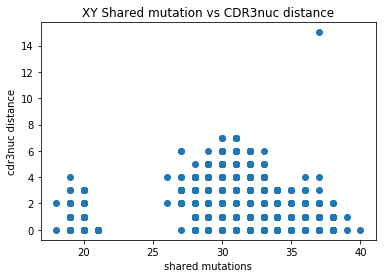

In [22]:
df_sel = df[df["myfunc"] > threshold]
fig, ax = plt.subplots()
ax.scatter(df_sel['Shared mutations'], df_sel['cdr3_distance'])
plt.title("XY Shared mutation vs CDR3nuc distance")
plt.xlabel('shared mutations')
plt.ylabel('cdr3nuc distance')
fig.show()

In [23]:
# Inspect entries with largest cdr3 distance
df_sel.sort_values(by='cdr3_distance', ascending=False).head()

,Reference,Antibody 1,Antibody 2,Shared mutations,Perc AB1,Perc AB2,cdr3_AB1,cdr3_AB2,cdr3_distance,myfunc
749247,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1114:11505:4148|M...,M02984:889:000000000-JGK5F:1:1114:27663:18350|...,37,100.0,100.0,M02984:889:000000000-JGK5F:1:2101:836,TGTGCGAGACACC,15,35.0
715788,IGHV4-39*01,M02984:889:000000000-JGK5F:1:1115:9832:2423|DO...,M02984:889:000000000-JGK5F:1:2108:15245:18548|...,31,91.2,86.1,TGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTCCTTTGACC...,TGTACGAGACTGCCAGTCGGAGCCCCTGCAGAGTATAACTTTGGCC...,7,36.0
728829,IGHV4-39*01,M02984:889:000000000-JGK5F:1:2108:15245:18548|...,M02984:889:000000000-JGK5F:1:1103:16255:9246|D...,31,86.1,86.1,TGTACGAGACTGCCAGTCGGAGCCCCTGCAGAGTATAACTTTGGCC...,TGTACGAGACTGCCAGTCGGTGCCCCTGAAGAGTATTACTTTGACC...,7,36.0
728773,IGHV4-39*01,M02984:889:000000000-JGK5F:1:2108:15245:18548|...,M02984:889:000000000-JGK5F:1:1102:5891:6664|DO...,31,86.1,91.2,TGTACGAGACTGCCAGTCGGAGCCCCTGCAGAGTATAACTTTGGCC...,TGTACGAGACTGCCAGTCGGAGCCCCTGAAGAGTATTACCTTGACC...,7,36.0
728847,IGHV4-39*01,M02984:889:000000000-JGK5F:1:2108:15245:18548|...,M02984:889:000000000-JGK5F:1:2107:9873:9496|DO...,30,83.3,93.8,TGTACGAGACTGCCAGTCGGAGCCCCTGCAGAGTATAACTTTGGCC...,TGTACGAGACCGCCAGTCGGAGCCCCTGAAGAGTATTACTTTGACC...,7,35.5


## Create clonal groups

In [24]:
import igraph
import math

In [25]:
# Create nodes in a graph
ids = list(set(list(df_sel['Antibody 1']) + list(df_sel['Antibody 2'])))
g = igraph.Graph(len(ids), directed=False)
g.vs["id"] = range(len(ids))
g.vs["name"] = ids
g.vs["label"] = ids
#g.vs["freq"] = freqs
#g.vs["size"] = [math.log(f) for f in freqs]

In [26]:
# Add the vertex numbers to the dataframe
df_ids = pd.DataFrame({'idx': range(len(ids)), 'antibody': ids})
df_sel = pd.merge(df_sel, df_ids, left_on="Antibody 1", right_on="antibody")
df_sel = df_sel.rename(columns={'idx': 'idx_AB1'})
df_sel = pd.merge(df_sel, df_ids, left_on="Antibody 2", right_on="antibody")
df_sel = df_sel.rename(columns={'idx': 'idx_AB2'})

In [ ]:
# Add edges to the graph
for index, row in df_sel.iterrows():
    g.add_edge(row['idx_AB1'], row['idx_AB2'], weight=1)

In [ ]:
# Plot the graph
w = 10
h = 10
d = 70
plt.figure(figsize=(w, h), dpi=d)
igraph.plot(g, vertex_label=None)

In [ ]:
# Get clusters of connected nodes
g_clusters = g.clusters(mode="strong")
cluster_id = list()
cluster_size = list()
vertex_id = list()
vertex_name = list()

i = 0
for c in g_clusters:
    size = len(c)
    for node in c:
        cluster_id.append(i)
        cluster_size.append(size)
        vertex_id.append(node)
        vertex_name.append(ids[node])
    i = i + 1
    
df_clusters = pd.DataFrame({'cluster_id': cluster_id, 'cluster_size': cluster_size, 'vertex_id': vertex_id, 'vertex_name': vertex_name})
df_clusters = df_clusters.sort_values(by=['cluster_size', 'cluster_id'], ascending=False)
df_clusters.head()

In [ ]:
df_clusters.to_csv(clusterfile, sep="\t", index=False)
print("Wrote", clusterfile, "to disk")